In [ ]:
# !pip install tensorflow

Vocab size: 20364
Number of tags: 23
Max sentence length: 84
X_train shape: (8086, 84)
y_train shape: (8086, 84, 23)
X_test shape: (2022, 84)
y_test shape: (2022, 84, 23)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 84, 100)        │     2,036,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 84, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 84, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 84, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 84, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 84, 23)         │         5,911 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,065,287 (11.69 MB)

 Trainable params: 3,065,287 (11.69 MB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.8306 - loss: 0.7325 - val_accuracy: 0.8932 - val_loss: 0.3546
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8918 - loss: 0.3606 - val_accuracy: 0.8971 - val_loss: 0.3357
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9002 - loss: 0.3259 - val_accuracy: 0.9183 - val_loss: 0.2558
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9234 - loss: 0.2383 - val_accuracy: 0.9441 - val_loss: 0.1774
Epoch 5/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9464 - loss: 0.1610 - val_accuracy: 0.9510 - val_loss: 0.1514
Epoch 6/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.9551 - loss: 0.1323 - val_accuracy: 0.9538 - val_loss: 0.1430
Epoch 7/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9598 - loss: 0.1164 - val_accuracy: 0.9545 - val_loss: 0.1395
Epoch 8/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9

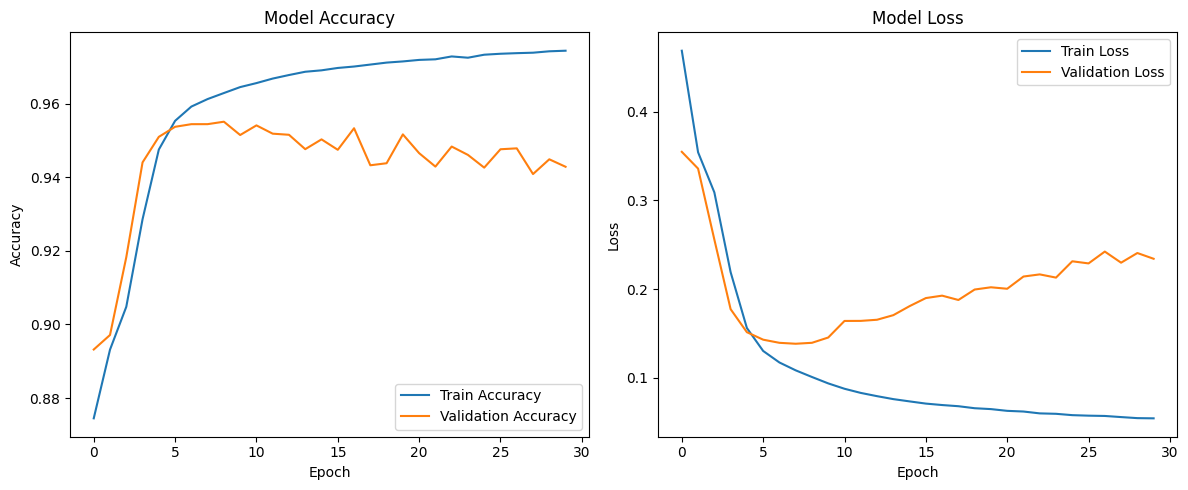

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, TimeDistributed
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
import matplotlib.pyplot as plt

# --- Configuration ---
DATA_FILE = '/content/pos_tagged_marathi.csv'
EMBEDDING_DIM = 100
LSTM_UNITS = 128
BATCH_SIZE = 64
EPOCHS = 30
TEST_SIZE = 0.2

# Define the allowed POS tags
ALLOWED_POS_TAGS = [
    'NN', 'NST', 'NNP', 'PRP', 'DEM', 'VM', 'VAUX', 'JJ', 'RB', 'PSP',
    'RP', 'QF', 'QC', 'CC', 'WQ', 'QO', 'INTF', 'INJ', 'NEG', 'SYM',
    'XC', 'UNK' # UNK must be in the list as it's a target
]

# --- Load the dataset ---
if not os.path.exists(DATA_FILE):
    print(f"Error: {DATA_FILE} not found. Please upload it to your Colab session.")
    exit()

df = pd.read_csv(DATA_FILE)

# Preprocess the data
df.columns = df.columns.str.strip()
df.dropna(subset=['Tokenized Sentence', 'POS Tags'], inplace=True)
df = df[df['Tokenized Sentence'].astype(str).str.strip() != '']
df = df[df['POS Tags'].astype(str).str.strip() != '']

# Handle potential float values by converting them to strings before splitting
sentences = df['Tokenized Sentence'].astype(str).apply(lambda x: x.split()).tolist()
original_pos_tags_nested = df['POS Tags'].astype(str).apply(lambda x: x.split()).tolist()

# --- Map original POS tags to allowed set or 'UNK' ---
processed_pos_tags = []
for sentence_tags in original_pos_tags_nested:
    new_sentence_tags = []
    for tag in sentence_tags:
        if tag in ALLOWED_POS_TAGS:
            new_sentence_tags.append(tag)
        else:
            new_sentence_tags.append('UNK') # Assign 'UNK' if not in the allowed list
    processed_pos_tags.append(new_sentence_tags)

# --- Create vocabulary and POS tag sets ---
word_tokenizer = Tokenizer(oov_token='<OOV>')
word_tokenizer.fit_on_texts(sentences)
vocab_size = len(word_tokenizer.word_index) + 1 # +1 for padding/OOV

# Use the processed_pos_tags for tag_tokenizer
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(processed_pos_tags)
num_tags = len(tag_tokenizer.word_index) + 1 # +1 for padding

# Verify that all ALLOWED_POS_TAGS are in the tokenizer's word_index
# If 'UNK' is not present, it implies no unknown tags were found in the data,
# but it's good practice to ensure it's mapped.
if 'UNK' not in tag_tokenizer.word_index:
    print("Warning: 'UNK' tag not found in dataset. Ensure 'UNK' is correctly handled if it's expected.")
    # You might want to manually add 'UNK' to word_index if it's strictly required
    # and not present in the processed_pos_tags for some reason.
    # However, if it's only for output and not present in training data, it's fine.

# Convert words and tags to sequences
X = word_tokenizer.texts_to_sequences(sentences)
y = tag_tokenizer.texts_to_sequences(processed_pos_tags) # Use processed tags here

# --- Pad sequences ---
max_len = max(len(s) for s in sentences)
X = pad_sequences(X, maxlen=max_len, padding='post')
y = pad_sequences(y, maxlen=max_len, padding='post')

# --- Convert y to categorical (one-hot encoding) ---
y = tf.keras.utils.to_categorical(y, num_classes=num_tags)

# --- Split into train and test sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

print(f"Vocab size: {vocab_size}")
print(f"Number of tags: {num_tags}")
print(f"Max sentence length: {max_len}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len),
    Dropout(0.3),
    Bidirectional(LSTM(units=LSTM_UNITS,
                       return_sequences=True,
                       activation='tanh')),
    Dropout(0.3),
    Bidirectional(LSTM(units=LSTM_UNITS,
                       return_sequences=True,
                       activation='tanh')),
    Dropout(0.3),
    Bidirectional(LSTM(units=LSTM_UNITS,
                       return_sequences=True,
                       activation='tanh')),
    Dropout(0.3),
    TimeDistributed(Dense(num_tags, activation='softmax'))
])

# --- Compile the model ---
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- Model summary ---
model.build(input_shape=(None, max_len))
model.summary()
print("\nTraining the model...")
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    verbose=1)

# --- Corrected evaluation function ---
def evaluate_model(model, X_test, y_test, tag_tokenizer):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=-1)
    y_test_original_ids = np.argmax(y_test, axis=-1)

    y_pred_flat = y_pred.flatten()
    y_test_flat = y_test_original_ids.flatten()

    idx_to_tag = {v: k for k, v in tag_tokenizer.word_index.items()}
    if 0 not in idx_to_tag and tag_tokenizer.word_index.get('pad_token') is None:
        idx_to_tag[0] = '<PAD>'

    mask = y_test_flat != 0
    y_pred_filtered = y_pred_flat[mask]
    y_test_filtered = y_test_flat[mask]

    unique_labels_in_test = np.unique(y_test_filtered).tolist()
    report_target_names = [idx_to_tag[label_id] for label_id in sorted(unique_labels_in_test)]

    print("\n--- Evaluation Report (Ignoring Padding) ---")
    print(classification_report(y_test_filtered, y_pred_filtered,
                                labels=sorted(unique_labels_in_test),
                                target_names=report_target_names,
                                zero_division=0))

evaluate_model(model, X_test, y_test, tag_tokenizer)

# --- Plot training history ---
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history)

In [ ]:
# --- Function to predict POS tags for a new sentence ---
def predict_pos_tags(sentence, model, word_tokenizer, tag_tokenizer, max_len):
    # 1. Tokenize the input sentence
    # Ensure the sentence is a list of words for tokenization
    if isinstance(sentence, str):
        words = sentence.split() # Simple split, consider more advanced tokenization for real applications
    else:
        words = sentence # Assume it's already a list of words

    # Convert words to sequences using the fitted word_tokenizer
    # Use texts_to_sequences, which handles OOV tokens automatically if configured
    sequence = word_tokenizer.texts_to_sequences([words])

    # 2. Pad the sequence to the same max_len
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    # 3. Make a prediction
    predictions = model.predict(padded_sequence)

    # 4. Decode the predictions
    # Get the index of the highest probability for each word
    predicted_tag_indices = np.argmax(predictions, axis=-1)[0] # [0] because predict returns a batch

    # Create inverse map for tag IDs to names
    idx_to_tag = {v: k for k, v in tag_tokenizer.word_index.items()}
    # Ensure PAD (0) is included if it's not in word_index
    if 0 not in idx_to_tag and tag_tokenizer.word_index.get('pad_token') is None:
        idx_to_tag[0] = '<PAD>' # Or whatever your padding token is, if any

    # Filter out padding tokens and map indices to tag names
    predicted_tags = []
    for i, tag_id in enumerate(predicted_tag_indices):
        # Only process if it's not a padding token and within the original sentence length
        if tag_id != 0 and i < len(words): # Check against original words length
            predicted_tags.append(idx_to_tag.get(tag_id, 'UNKNOWN_TAG_ID')) # Fallback for safety

    # Align predictions with original words for display
    # We need to consider that `words` might be shorter than `max_len`
    # and we only want predictions for the actual words.
    aligned_output = []
    for i, word in enumerate(words):
        if i < len(predicted_tags): # Ensure we don't go out of bounds for predicted_tags
            aligned_output.append(f"{word}/{predicted_tags[i]}")
        else:
            # This case ideally shouldn't happen if max_len is sufficient and padding is 'post'
            aligned_output.append(f"{word}/<NO_PREDICTION>")

    return " ".join(aligned_output)

# --- Example Usage for a new sentence ---
print("\n--- Testing with a Custom Sentence ---")

test_sentence_1 = "रोहित पवार पक्षाचे नवे अध्यक्ष."
predicted_output_1 = predict_pos_tags(test_sentence_1, model, word_tokenizer, tag_tokenizer, max_len)
print(f"Sentence: '{test_sentence_1}'")
print(f"Predicted POS: {predicted_output_1}")
print("-" * 30)



--- Testing with a Custom Sentence ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Sentence: 'रोहित पवार पक्षाचे नवे अध्यक्ष.'
Predicted POS: रोहित/nnp पवार/nnp पक्षाचे/nn नवे/jj अध्यक्ष./nn
------------------------------


In [ ]:
# --- Print final accuracy and loss ---
print("\n--- Final Training and Validation Metrics ---")
print(f"Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Train Loss: {history.history['loss'][-1]:.4f}")
print(f"Validation Loss: {history.history['val_loss'][-1]:.4f}")


--- Final Training and Validation Metrics ---
Train Accuracy: 0.9745
Validation Accuracy: 0.9429
Train Loss: 0.0544
Validation Loss: 0.2342


In [ ]:
# Assuming your model has already been trained and X_test, y_test are available.

print("\n--- Evaluating Model on Test Set ---")

# Evaluate the model on the test data
# model.evaluate returns the loss value and metrics values for the model in test mode.
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0) # verbose=0 to suppress per-batch output

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

print("-" * 30)


--- Evaluating Model on Test Set ---
Test Loss: 0.2342
Test Accuracy: 0.9429
------------------------------


In [ ]:
model.save("model_bilstm.h5")
import pickle

with open("word_tokenizer.pkl", "wb") as f:
    pickle.dump(word_tokenizer, f)

with open("tag_tokenizer.pkl", "wb") as f:
    pickle.dump(tag_tokenizer, f)
